In [1]:
import numpy as np
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import glob
import sys, os
sys.path.append(os.pardir) # 부모 디렉토리의 파일을 가져올 수 있도록 설정
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from collections import OrderedDict
import pickle
import torch
%matplotlib inline
import cv2
from imutils.video import VideoStream

print('GPU 사용 가능 여부: {}'.format(torch.cuda.is_available()))
device = "cuda" if torch.cuda.is_available() else "CPU"

GPU 사용 가능 여부: False


In [2]:
from pathlib import Path

folder = "Anaconda/Baram"
project_dir = "MaskClassificaion"

base_path = Path("/Users/yuchul/")
project_path = base_path / folder / project_dir
os.chdir(project_path)
for x in list(project_path.glob("*")):
    if x.is_dir():
        dir_name = str(x.relative_to(project_path))
        os.rename(dir_name, dir_name.split(" ", 1)[0])
print(f"현재 디렉토리 위치: {os.getcwd()}")

현재 디렉토리 위치: /Users/yuchul/Anaconda/Baram/MaskClassificaion


In [3]:
current_path = Path().absolute()
data_path = current_path / "data_old"

In [4]:
print("현재 디렉토리 위치: {}".format(current_path))

현재 디렉토리 위치: /Users/yuchul/Anaconda/Baram/MaskClassificaion


In [5]:
if (data_path / "mask_cnn").exists():
    print("이미 'data/mask_cnn' 폴더가 있습니다! 이어서 진행하세요~")
else: print("없습니다")

이미 'data/mask_cnn' 폴더가 있습니다! 이어서 진행하세요~


In [6]:
data_dir = './data_old/mask_cnn'

In [7]:
print(data_path)

/Users/yuchul/Anaconda/Baram/MaskClassificaion/data_old


In [8]:
batch_size = 32
num_epochs = 30
learning_rate = 0.0001

In [9]:
class MaskNonMaskDataset(Dataset):
    def __init__(self, data_dir, mode=None, transform=None, train_size=None):
        self.all_data = sorted(glob.glob(os.path.join(data_dir, mode, '*', '*')))
        
        #RGB 가 아닌 파일필터링
#         self.all_data = [i for i in self.old_all_data if transform(Image.open(i)).shape[0] == 3]
    
        self.mode = mode
        self.transform = transform
        self.train_size = train_size
    
    def __getitem__(self, index):
        
        data_path = self.all_data[index]
        img = Image.open(data_path)
        if self.transform != None:
            img = self.transform(img)
        
        if os.path.basename(data_path).startswith("Mask"):
            label = 0
        else:
            label = 1
            
        return img, label # [1, 0, 0] , [0, 1, 0], [0, 0, 1]
    
    def __len__(self):
        length = len(self.all_data)
        return length

In [10]:
print(data_dir)

./data_old/mask_cnn


In [11]:
!ls ./data_old/mask_cnn/Train

Mask     Non_Mask


In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

In [13]:
data_transforms = {
    'train' : transforms.Compose([
        transforms.RandomRotation(5),
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop(224, scale=(0.96, 1.0), ratio=(0.95, 1.05)),
        transforms.ToTensor(),
        # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val' : transforms.Compose([
        transforms.Resize([224, 224]),
        transforms.ToTensor(),
        # transforms.Normalize([0.485,  0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# train_data = MaskNonMaskDataset(data_dir='./data/mask_cnn', mode='Train', transform=data_transforms['train'])
# val_data = MaskNonMaskDataset(data_dir='./data/mask_cnn', mode='Validation', transform=data_transforms['val'])
# test_data = MaskNonMaskDataset(data_dir='./data/mask_cnn', mode='Test', transform=data_transforms['val'])

# train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
# val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True, drop_last=True)
# test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, drop_last=True)

In [59]:
train_data = torchvision.datasets.ImageFolder(root='./data_old/mask_cnn/Train', transform=data_transforms['train'])
val_data = torchvision.datasets.ImageFolder(root='./data_old/mask_cnn/Validation', transform=data_transforms['val'])
test_data = torchvision.datasets.ImageFolder(root='./data_old/mask_cnn/Test', transform=data_transforms['val'])

add_data = torchvision.datasets.ImageFolder(root='./data_old/mask_cnn/add_data/Train_', transform=None)

In [61]:
for num, value in enumerate(add_data):
    data, label = value
    
#     print(num, label)
    
    if num ==3:
        print(num, data, label) 
    
#     if(label == 0):
#         data.save('./data_old/mask_cnn/add_data/Train/Mask/%s_%d_%d.jpg'%("Mask" ,num, label))
#     else:
#         data.save('./data_old/mask_cnn/add_data/Train/NonMask/%s_%d_%d.jpg'%("NonMask", num, label))
        

3 <PIL.Image.Image image mode=RGB size=53x53 at 0x7FE69AB400A0> 0


In [62]:
add_data = torchvision.datasets.ImageFolder(root='./data_old/mask_cnn/add_data/Train', transform=data_transforms['train'])

In [63]:
temp1 = glob.glob(os.path.join(data_dir, "Train", '*', '*'))
temp2 = glob.glob(os.path.join(data_dir, "validation", '*', '*'))
temp3 = glob.glob(os.path.join(data_dir, "test", '*', '*'))
print(len(temp1), len(temp2), len(temp3))

18238 395 100


In [64]:
print(len(train_data))
print(len(val_data))
print(len(test_data))
x_train = []
t_train = []

18238
395
100


In [65]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, drop_last=True)

In [66]:
class ReLU:
    def __init__(self):
        self.mask = None

    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0
        
        return out

    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout

        return dx

In [67]:
def get_grad(f, x):
    h = 1e-4 #0.0001
    grad = np.zeros_like(x)
    
    it = np.nditer(x, flag=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        idx = it.multi_index
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + h
        fxh1 = f(x) #f(x+h)
        
        x[idx] = tmp_val - h
        fxh2 = f(x) #f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2*h)
        
        x[idx] = tmp_val # 값 복원
        it.iternext()
        
    return grad

In [68]:
class Adam:
    
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
    
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)
        
        self.iter += 1
        lr_t = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)
        
        for key in params.keys():
#             print("계산 전 m[key]: ", self.m[key].shape)
#             print("계산 전 grads[key]: ", grads[key].shape)
            self.m[key] = self.beta1*self.m[key] + (1-self.beta1)*grads[key]
            self.v[key] = self.beta2*self.v[key] + (1-self.beta2)*(grads[key]**2)
#             print("key: ", key)
#             print("m키값", self.m[key].shape)
#             print("grads키값", grads[key].shape)
#             print("v키값", self.v[key].shape)
                  
#             self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
#             self.v[key] += (1 - self.beta2) * (grads[key]**2 - self.v[key])
            
            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)
            
#             print("params키값", params[key].shape)
            
            #unbias_m += (1 - self.beta1) * (grads[key] - self.m[key]) # correct bias
            #unbisa_b += (1 - self.beta2) * (grads[key]*grads[key] - self.v[key]) # correct bias
            #params[key] += self.lr * unbias_m / (np.sqrt(unbisa_b) + 1e-7)

In [69]:
class FC_Layer:
    
    def __init__(self, W, b):
        self.W = W
        self.b = b
        
        self.x = None
        self.original_x_shape = None
        #가중치와 편향 매개변수 미분
        self.dW = None
        self.db = None
        
    def forward(self, x):
        #텐서 대응
#         print("FC입력", x.shape)
#         print("가중치", self.W.shape)
        self.original_x_shape = x.shape
        x = x.reshape(x.shape[0], -1)
        self.x = x
#         print("FC reshape 입력", x.shape)
        out = np.dot(self.x, self.W) + self.b
#         print("FC출력", out.shape)
        return out
    
    def backward(self, dout):
#         print("FC back입력", dout.shape)
        dx = np.dot(dout, self.W.T) #.T는 Transpose
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)
        
        dx = dx.reshape(*self.original_x_shape) # 입력 데이터 모양 변경(텐서 대응)
#         print("FC back출력", dx.shape)
        return dx

In [70]:
class Dropout:
    
    def __init__(self, dropout_ratio=0.5):
        self.dropout_ratio = dropout_ratio
        self.mask = None
    
    def forward(self, x, train_flg=True):
        if train_flg:
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio 
            # x모양에 맞춰서 랜덤한 행렬생성, 원소별 0~1 사이의 랜던한 값, 
            #그 값이 dropout_ratio보다 큰 값이 true, 작으면 false인 행렬을 mask에 저장
            return x * self.mask
        else:
            return x * (1.0 - self.dropout_ratio)
        
    def backward(self, dout):
        return dout * self.mask

In [71]:
def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    """다수의 이미지를 입력받아 2차원 배열로 변환한다(평탄화).
    
    Parameters
    ----------
    input_data : 4차원 배열 형태의 입력 데이터(이미지 수, 채널 수, 높이, 너비)
    filter_h : 필터의 높이
    filter_w : 필터의 너비
    stride : 스트라이드
    pad : 패딩
    
    Returns
    -------
    col : 2차원 배열
    """
    N, C, H, W = input_data.shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1

    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]

    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
    return col

In [72]:
def col2im(col, input_shape, filter_h, filter_w, stride=1, pad=0):
    """(im2col과 반대) 2차원 배열을 입력받아 다수의 이미지 묶음으로 변환한다.
    
    Parameters
    ----------
    col : 2차원 배열(입력 데이터)
    input_shape : 원래 이미지 데이터의 형상（예：(10, 1, 28, 28)）
    filter_h : 필터의 높이
    filter_w : 필터의 너비
    stride : 스트라이드
    pad : 패딩
    
    Returns
    -------
    img : 변환된 이미지들
    """
    # print(pad)
    N, C, H, W = input_shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1
    col = col.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(0, 3, 4, 5, 1, 2)

    img = np.zeros((N, C, H + 2*pad + stride - 1, W + 2*pad + stride - 1))
    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            img[:, :, y:y_max:stride, x:x_max:stride] += col[:, :, y, x, :, :]

    return img[:, :, pad:H + pad, pad:W + pad]

In [73]:
def shuffle_dataset(x, t):
    """데이터셋을 뒤섞는다.
    Parameters
    ----------
    x : 훈련 데이터
    t : 정답 레이블
    
    Returns
    -------
    x, t : 뒤섞은 훈련 데이터와 정답 레이블
    """
    permutation = np.random.permutation(x.shape[0])
    x = x[permutation,:] if x.ndim == 2 else x[permutation,:,:,:]
    t = t[permutation]

    return x, t

In [74]:
class BatchNormalization:
    
    def __init__(self, gamma, beta, momentum=0.9, running_mean=None, running_var=None):
        self.gamma = gamma
        self.beta = beta
        self.momentum = momentum
        self.input_shape = None # 합성곱 계층은 4차원, 완전연결 계층은 2차원  

        # 시험할 때 사용할 평균과 분산
        self.running_mean = running_mean
        self.running_var = running_var  
        
        # backward 시에 사용할 중간 데이터
        self.batch_size = None
        self.xc = None
        self.std = None
        self.dgamma = None
        self.dbeta = None

    def forward(self, x, train_flg=True):
#         print("BN 입력", x.shape)
        self.input_shape = x.shape
        if x.ndim != 2:
            N, C, H, W = x.shape
            x = x.reshape(N, -1)

        out = self.__forward(x, train_flg)
#         print("BN 출력", out.reshape(*self.input_shape).shape)       
        return out.reshape(*self.input_shape)
            
    def __forward(self, x, train_flg):
        if self.running_mean is None:
            N, D = x.shape
            self.running_mean = np.zeros(D)
            self.running_var = np.zeros(D)
                        
        if train_flg:
            mu = x.mean(axis=0)
            xc = x - mu
            var = np.mean(xc**2, axis=0)
            std = np.sqrt(var + 10e-7)
            xn = xc / std
            
            self.batch_size = x.shape[0]
            self.xc = xc
            self.xn = xn
            self.std = std
            self.running_mean = self.momentum * self.running_mean + (1-self.momentum) * mu
            self.running_var = self.momentum * self.running_var + (1-self.momentum) * var            
        else:
            xc = x - self.running_mean
            xn = xc / ((np.sqrt(self.running_var + 10e-7)))
            
        out = self.gamma * xn + self.beta 
        return out

    def backward(self, dout):
#         print('BN back입력', dout.shape)
        if dout.ndim != 2:
            N, C, H, W = dout.shape
            dout = dout.reshape(N, -1)

        dx = self.__backward(dout)
#         print('BN back출력 reshape전', dx.shape)
        
        dx = dx.reshape(*self.input_shape)
#         print('BN back출력 reshape후', dx.shape)
        return dx

    def __backward(self, dout):
        dbeta = dout.sum(axis=0)
        dgamma = np.sum(self.xn * dout, axis=0)
        dxn = self.gamma * dout
        dxc = dxn / self.std
        dstd = -np.sum((dxn * self.xc) / (self.std * self.std), axis=0)
        dvar = 0.5 * dstd / self.std
        dxc += (2.0 / self.batch_size) * self.xc * dvar
        dmu = np.sum(dxc, axis=0)
        dx = dxc - dmu / self.batch_size
        
        self.dgamma = dgamma
        self.dbeta = dbeta
        
        return dx

In [75]:
class Convolution:
    def __init__(self, W, b, stride=None, pad=None):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad
        
        # 중간 데이터（backward 시 사용）
        self.x = None   
        self.col = None
        self.col_W = None
        
        # 가중치와 편향 매개변수의 기울기
        self.dW = None
        self.db = None

    def forward(self, x):
#         print("Con입력값=", x.shape)
#         print("가중치", self.W.shape)
        FN, C, FH, FW = self.W.shape
        N, C, H, W = x.shape
        out_h = 1 + int((H + 2*self.pad - FH) / self.stride)
        out_w = 1 + int((W + 2*self.pad - FW) / self.stride)
#         print("out_h=", out_h)
#         print("out_w=", out_w)
        col = im2col(x, FH, FW, self.stride, self.pad)
        col_W = self.W.reshape(FN, -1).T

        out = np.dot(col, col_W) + self.b
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)

        self.x = x
        self.col = col
        self.col_W = col_W
#         print("Con출력값", out.shape)
        return out

    def backward(self, dout):
#         print("Con back입력", dout.shape)
        FN, C, FH, FW = self.W.shape
        dout = dout.transpose(0,2,3,1).reshape(-1, FN)

        self.db = np.sum(dout, axis=0)
        self.dW = np.dot(self.col.T, dout)
        self.dW = self.dW.transpose(1, 0).reshape(FN, C, FH, FW)

        dcol = np.dot(dout, self.col_W.T)
        dx = col2im(dcol, self.x.shape, FH, FW, self.stride, self.pad)
#         print("Con back출력", dx.shape)
        return dx

In [76]:
class Pooling:
    def __init__(self, pool_h, pool_w, stride, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad
        
        self.x = None
        self.arg_max = None

    def forward(self, x):
#         print("Pool 입력", x.shape)
        N, C, H, W = x.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)

        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h*self.pool_w)

        arg_max = np.argmax(col, axis=1)
        out = np.max(col, axis=1)
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)

        self.x = x
        self.arg_max = arg_max
#         print("Pool 출력", out.shape)  
        return out

    def backward(self, dout):
#         print("Pool back입력", dout.shape)
        dout = dout.transpose(0, 2, 3, 1)
        
        pool_size = self.pool_h * self.pool_w
        dmax = np.zeros((dout.size, pool_size))
        dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten()
        dmax = dmax.reshape(dout.shape + (pool_size,)) 
        
        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
        dx = col2im(dcol, self.x.shape, self.pool_h, self.pool_w, self.stride, self.pad)
#         print("Pool back출력", dx.shape)
        return dx

In [77]:
def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T 

    x = x - np.max(x) # 오버플로 대책
    return np.exp(x) / np.sum(np.exp(x))

In [78]:
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # 훈련 데이터가 원-핫 벡터라면 정답 레이블의 인덱스로 반환
    if t.size == y.size:
        t = t.argmax(axis=1)
    
    
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size
        

In [79]:
class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None #손실함수
        self.y = None #softmax의 출력
        self.t = None #정답 레이블(원-핫 인코딩 형태)
    
    def forward(self, x, t):
        
#         print("SoftmaxWithLoss의 t", t.shape)
        
        self.t = t
        self.y = softmax(x)
        
#         print("Softmax(x) = y: ", self.y.shape)

        self.loss = cross_entropy_error(self.y, self.t)
        
#         print("크로스엔트로피에러함수", self.loss.shape)
#         print("크로스엔트로피에러함수", self.loss)
        
        return self.loss
    
    def backward(self, dout=1):
        
        batch_size = self.t.shape[0]
        
#         print("SoftmaxWithLoss back의 batchsize", batch_size)

#         print("SoftmaxWithLoss back의 y모양", self.y.shape)
#         print("SoftmaxWithLoss back의 t모양", self.t.shape)
#         print("SoftmaxWithLoss back의 y", self.y)
#         print("SoftmaxWithLoss back의 t", self.t)
        
        if self.t.size == self.y.size: #정답 레이블이 원-핫 인코딩 형태일 때
            dx = (self.y - self.t) / batch_size
        else:
            dx = self.y.copy()
            dx[np.arange(batch_size), self.t] -= 1
            dx = dx / batch_size
        
#         print("SoftmaxWithLoss back의 dx", dx.shape)
        return dx

In [80]:
# import numba
class VGG6:
    
    def __init__(self, input_dim={3, 224, 224},
                 conv_param_1 = {'filter_num':16, 'filter_size':3, 'pad':1, 'stride':2},
                 conv_param_2 = {'filter_num':32, 'filter_size':3, 'pad':1, 'stride':1},
                 conv_param_3 = {'filter_num':32, 'filter_size':3, 'pad':1, 'stride':2},
                 conv_param_4 = {'filter_num':64, 'filter_size':3, 'pad':1, 'stride':2},
                 hidden_size=50, output_size=2):
        
        self.first_flg = True
        
        # ======= 가중치 초기화 =======
        
        pre_node_nums = np.array([3*3*3, 16*3*3, 32*3*3, 32*3*3, 64*7*7, hidden_size])
        weight_init_scales = np.sqrt(2.0 / pre_node_nums) # ReLU 사용할 때 권장 초깃값
        
        self.params = {}
        pre_channel_num = 3
        for idx, conv_param in enumerate([conv_param_1, conv_param_2, conv_param_3, conv_param_4]):
            self.params['W' + str(idx+1)] = weight_init_scales[idx] * np.random.randn(conv_param['filter_num'], pre_channel_num, conv_param['filter_size'], conv_param['filter_size'])
            self.params['b' + str(idx+1)] = np.zeros(conv_param['filter_num'])
            pre_channel_num = conv_param['filter_num']
            self.params['gamma' + str(idx+1)] = 1.0
            self.params['beta' + str(idx+1)] = 0.0
            
        self.params['W5'] = weight_init_scales[4] * np.random.randn(64*7*7, hidden_size)
        self.params['b5'] = np.zeros(hidden_size)
        self.params['W6'] = weight_init_scales[5] * np.random.randn(hidden_size, output_size)
        self.params['b6'] = np.zeros(output_size)
        
        # ======= 계층 생성 =======
        
        self.layers = []
        
        self.layers.append(Convolution(self.params['W1'], self.params['b1'], conv_param_1['stride'], conv_param_1['pad'])) # 0
        self.layers.append(BatchNormalization(self.params['gamma1'], self.params['beta1'])) #1
        self.layers.append(ReLU())
        
        self.layers.append(Convolution(self.params['W2'], self.params['b2'], conv_param_2['stride'], conv_param_2['pad'])) # 3
        self.layers.append(BatchNormalization(self.params['gamma2'], self.params['beta2'])) #4
        self.layers.append(ReLU())
        self.layers.append(Pooling(pool_h=2, pool_w=2, stride=2))
        
        self.layers.append(Convolution(self.params['W3'], self.params['b3'], conv_param_3['stride'], conv_param_3['pad'])) # 7
        self.layers.append(BatchNormalization(self.params['gamma3'], self.params['beta3'])) #8
        self.layers.append(ReLU())
        
        self.layers.append(Convolution(self.params['W4'], self.params['b4'], conv_param_4['stride'], conv_param_4['pad'])) # 10
        self.layers.append(BatchNormalization(self.params['gamma4'], self.params['beta4']))#11
        self.layers.append(ReLU())
        self.layers.append(Pooling(pool_h=2, pool_w=2, stride=2))
        
        self.layers.append(FC_Layer(self.params['W5'], self.params['b5'])) # 14
#         self.layers.append(ReLU())
#         self.layers.append(Dropout(0.5))
        self.layers.append(FC_Layer(self.params['W6'], self.params['b6'])) # 17
#         self.layers.append(ReLU())
#         self.layers.append(Dropout(0.5))
        
#         self.layers.append(SoftmaxWithLoss())
        
        self.last_layer = SoftmaxWithLoss()
        
    def predict(self, x, train_flg=False, first_flg=None):
        
        for layer in self.layers:
            if isinstance(layer, Dropout):
                if self.first_flg and isinstance(layer, BatchNormalization):
                    x = layer.__forward(x, train_flg)
                else:
                    x = layer.forward(x, train_flg)
            
            else:
                x = layer.forward(x)
                     
        return x
    
    def loss(self, x, t):
        y = self.predict(x, train_flg=True, first_flg=self.first_flg)
        self.first_flg = False
        return self.last_layer.forward(y, t)
    
    def accuracy(self, x, t, batch_size=32):
        if t.ndim != 1 : t = np.argmax(t, axis=1)

        acc = 0.0

        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx, train_flg=False)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt)

        return acc / x.shape[0]
    
#     def accuracy(self, inputs, labels):
        
#         # 0, 1 -> [1, 0], [0, 1]
#          for i in range()
        
#         if t.ndim != 1 : t = np.argmax(t, axis=1)
            
#         acc = 0.0
        
#         for i in range(int(x.shape[0] / batch_size)):
#             tx = x[i*batch_size:(i+1)*batch_size]
#             tt = t[i*batch_size:(i+1)*batch_size]
#             y = self.predict(tx, train_flg=False)
#             y = np.argmax(y, axis=1)
#             acc += np.sum(y == tt)
        
#         return acc / x.shape[0]
    
    def gradient(self, x, t):
        
        #forward
        self.loss(x, t)
        
        #backward
        dout = 1
        dout = self.last_layer.backward(dout)
                
        tmp_layers = self.layers.copy()
        tmp_layers.reverse()
        for layer in tmp_layers:
            dout = layer.backward(dout)

        #결과 저장
        grads = {}
        idx = 0
        
        for i, layer in enumerate(self.layers):
            
            if isinstance(layer, Convolution) or isinstance(layer, FC_Layer):

                grads['W' + str(idx+1)] = self.layers[i].dW
                grads['b' + str(idx+1)] = self.layers[i].db
                
                if(i==14):
                    idx += 1
                            
            elif isinstance(layer, BatchNormalization):
                grads['gamma'+str(idx+1)] = self.layers[i].dgamma
                grads['beta'+str(idx+1)] = self.layers[i].dbeta
                idx += 1
                
        return grads
                    
        
#         for i, layer_idx in enumerate((0, 1, 3, 4, 7, 8, 10, 11, 14, 17)):
#             # print("len(self.layers):",len(self.layers))
#             grads['W' + str(i+1)] = self.layers[layer_idx].dW
#             grads['b' + str(i+1)] = self.layers[layer_idx].db
#             grads['gamma'+str(i+1)] = self.layers[layer_idx].dgamma
#             grads['beta'+str(i+1)] = self.layers[layer_idx].dbeta
                
#         return grads
    
    def save_params(self, file_name='params.pkl'):
        params = {}
        for key, val in self.params.items():
            params[key] = val
        with open(file_name, 'wb') as f:
            pickle.dump(params, f)
        print("training network params:", self.params.keys())
        
        
    def load_params(self, file_name='epoch.pkl'):
        with open(file_name, 'rb') as f:
            params = pickle.load(f)
        for key, val in params.items():
            self.params[key] = val
        
#         for i, layer_idx in enumerate((0, 1, 3, 4, 7, 8, 10, 11, 14, 17)):
#             self.layers[layer_idx].W = self.params['W' + str(i+1)]
#             self.layers[layer_idx].b = self.params['b' + str(i+1)]
        
        idx = 0
        
        for i, layer in enumerate(self.layers):
            if isinstance(layer, Convolution) or isinstance(layer, FC_Layer):

                self.layers[i].W = self.params['W' + str(idx+1)]
                self.layers[i].b = self.params['b' + str(idx+1)]
                
                if(i==14):
                    idx += 1
                            
            elif isinstance(layer, BatchNormalization):
                self.layers[i].gamma = self.params['gamma'+str(idx+1)]
                self.layers[i].beta = self.params['beta'+str(idx+1)]
                idx += 1

        print("Params is successfully loaded!:", self.params.keys())

In [81]:
network = VGG6()

In [82]:
def graph(data_list, title, color, save_path):
    batch_num_list = [i for i in range(0, len(data_list))]

    plt.figure(figsize=(20, 10))
    plt.rc('font', size=25)
    plt.plot(batch_num_list, data_list, color=color, marker='o', linestyle='solid')
    plt.title(title)
    plt.xlabel('Epoch')
    
    title = plt.ylabel(title)

    plt.savefig(save_path, dpi=600)
    # plt.show()
    plt.close()

In [83]:
class Trainer:
    
    """신경망 훈련을 대신 해주는 클래스"""
    
    def __init__(self, network, x_train_loader, x_test_loader,
                 epochs=30, mini_batch_size=32,
                 optimizer='adagrad', optimizer_param={'lr':0.0001}, 
                 evaluate_sample_num_per_epoch=None, verbose=True):
        self.network = network
        # print(f"Network Spec: {self.network.keys()}")
        self.verbose = verbose
        self.train_loader = x_train_loader
        self.test_loader = x_test_loader
        # print(x_train[0][0][0][0])
#         self.x_train = x_train
#         self.t_train = t_train
#         self.x_test = x_test
#         self.t_test = t_test
#         self.epochs = epochs
        self.batch_size = mini_batch_size
        self.evaluate_sample_num_per_epoch = evaluate_sample_num_per_epoch

        # optimzer
        optimizer_class_dict = {'adam':Adam}
        self.optimizer = optimizer_class_dict[optimizer.lower()](**optimizer_param)
        
        self.train_size = len(x_train) # x_train.shape[0]
        self.iter_per_epoch = max(self.train_size / mini_batch_size, 1)
        self.epochs = epochs
        self.current_iter = 0
        self.current_epoch = 0
        
        self.train_loss_list = []
        self.train_acc_list = []
        self.test_acc_list = []
        self.train_mode = True

    def train_step(self):
#         batch_mask = np.random.choice(self.train_size, self.batch_size).tolist()
        
#         x_batch = []
#         t_batch = []

#         for idx in batch_mask:
#             x_batch.append(self.x_train[idx])
#             t_batch.append(self.t_train[idx])
            
        dataloader = self.train_loader if self.train_mode else self.test_loader
        name = "train" if self.train_mode else "evaluate"

        for x_batch, t_batch in dataloader:
#             print(x_batch.shape)
            grads = self.network.gradient(x_batch, t_batch)
            
#             for key in grads.keys():
#                 print(key, ":", grads[key].shape)
            self.optimizer.update(self.network.params, grads)
            loss = self.network.loss(x_batch, t_batch)
            
            if self.train_mode:
                self.train_loss_list.append(loss)
                
            if self.verbose: print(f"\t{name} loss: {loss}")

            if self.current_iter % self.iter_per_epoch == 0:
                self.current_epoch += 1
    
                x_train_sample, t_train_sample = x_batch, t_batch
                train_acc = self.network.accuracy(x_train_sample, t_train_sample)
            
            if self.train_mode:
                self.train_acc_list.append(train_acc)
            else:
                self.test_acc_list.append(test_acc)

                if self.verbose: print("=== epoch:" + str(self.current_epoch) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc) + " ===")
            self.current_iter += 1
            

    def train(self, current_epochs):
        for epoch in range(self.epochs):
            self.train_step()
            self.network.save_params(file_name=f"epoch_{epoch+current_epochs+1}.pkl")
            print(f"model({epoch+1}/{self.epochs}) is saved!")
            graph(self.train_loss_list, 'loss', 'red', f"epoch_{epoch+current_epochs+1}")

    def test(self, test_data_length = len(test_data)):
        hits = 0.0
        acc = 0.0
        for imgs, labels in self.test_loader:
            hits += self.network.accuracy(imgs, labels)
        acc = hist/test_data_length

        if self.verbose:
            print("=============== Final Test Accuracy ===============")
            print("test acc:" + str(test_acc))

In [84]:
trainer = Trainer(network, x_train_loader = train_loader, x_test_loader = test_loader,
                 epochs=15, mini_batch_size=32,
                 optimizer='Adam', optimizer_param={'lr':0.0001},
                 evaluate_sample_num_per_epoch=3)

# trainer.network.load_params(file_name='epoch_1.pkl')

trainer.train(0)

network.save_params("VGG6.pkl")
print("Saved Newwork Parameters!")

	train loss: 0.932920466646347
	train loss: 1.2462551918526121
	train loss: 1.2579625542757378
	train loss: 1.0372404111626599
	train loss: 1.1039877634988347
	train loss: 0.7768785958466948
	train loss: 1.0357872327505186
	train loss: 1.075600137638843
	train loss: 0.721568545174064
	train loss: 0.4968873597112372
	train loss: 0.8013717740289874
	train loss: 1.0052422613627683
	train loss: 1.1099211454327862
	train loss: 1.1080662388296219
	train loss: 0.9237806216784271
	train loss: 0.7426394244088946
	train loss: 0.6787362589845172
	train loss: 0.6565640511394739
	train loss: 0.4592017493579996
	train loss: 0.42357977034660144
	train loss: 0.5528648507275867
	train loss: 0.5881014713904753
	train loss: 0.7086240402659556
	train loss: 0.977522153834252
	train loss: 0.7283940744024928
	train loss: 0.7786790269942743
	train loss: 0.8127712568961745
	train loss: 0.5715624670614001
	train loss: 0.7064608486173649
	train loss: 0.6118853580871106
	train loss: 1.0566976274538749
	train loss

Params is successfully loaded!: dict_keys(['W1', 'b1', 'gamma1', 'beta1', 'W2', 'b2', 'gamma2', 'beta2', 'W3', 'b3', 'gamma3', 'beta3', 'W4', 'b4', 'gamma4', 'beta4', 'W5', 'b5', 'W6', 'b6'])
(1, 3, 224, 224)


array([[-0.03602253,  0.05814829]])

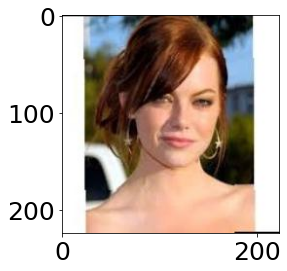

In [90]:
network.load_params('epoch_15.pkl')

img = cv2.imread('/Users/yuchul/Anaconda/Baram/MaskClassificaion/data_old/mask_cnn/Train/Non_Mask/586_1.jpg')
# img = cv2.imread('/Users/yuchul/Anaconda/Baram/MaskClassificaion/data_old/mask_cnn/Train/Mask/0_0.jpg')
img_resize = cv2.resize(img, dsize=(224, 224), interpolation=cv2.INTER_LINEAR)
fix_img = cv2.cvtColor(img_resize, cv2.COLOR_BGR2RGB)
fimg = fix_img.transpose(2,0,1)

fixed_img = np.expand_dims(fimg, axis=0)

print(fixed_img.shape)
# print(fixed_img.label)
imshow(fix_img)

network.predict(fixed_img)

In [89]:
labels_dict={0:'Mask',1:'NoMask'}
color_dict={1:(0,0,255),0:(0,255,0)}

size = 4
webcam = cv2.VideoCapture(0) #Use camera 0

# We load the xml file
classifier = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

while True:
    (rval, im) = webcam.read()
    im=cv2.flip(im,1,1) #Flip to act as a mirror

    # Resize the image to speed up detection
    mini = cv2.resize(im, (im.shape[1] // size, im.shape[0] // size))

    # detect MultiScale / faces 
    faces = classifier.detectMultiScale(mini)

    # Draw rectangles around each face
    for f in faces:
        (x, y, w, h) = [v * size for v in f] #Scale the shapesize backup
        #Save just the rectangle faces in SubRecFaces
        face_img = im[y:y+h, x:x+w]
        resized=cv2.resize(face_img,(224,224))
        normalized=resized/255.0
        reshaped=np.reshape(normalized,(1,3,224,224))
#         print(reshaped.shape)
#         reshaped = np.vstack([reshaped])
#         print(reshaped.shape)
        result=network.predict(reshaped)
        print(result)
        
        label=np.argmax(result,axis=1)[0]
      
        cv2.rectangle(im,(x,y),(x+w,y+h),color_dict[label],2)
        cv2.rectangle(im,(x,y-40),(x+w,y),color_dict[label],-1)
        cv2.putText(im, labels_dict[label], (x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.8,(255,255,255),2)
        
    # Show the image
    cv2.imshow('LIVE',   im)
    key = cv2.waitKey(100)
    # if Esc key is press then break out of the loop 
    if key == 27: #The Esc key
        break

[[-0.03602253  0.05814829]]
[[-0.03602253  0.05814829]]
[[-0.03602253  0.05814829]]
[[-0.03602253  0.05814829]]
[[-0.03602253  0.05814829]]
[[-0.03602253  0.05814829]]
[[-0.03602253  0.05814829]]
[[-0.03602253  0.05814829]]
[[-0.03602253  0.05814829]]
[[-0.03602253  0.05814829]]
[[-0.03602253  0.05814829]]
[[-0.03602253  0.05814829]]
[[-0.03602253  0.05814829]]
[[-0.03602253  0.05814829]]
[[-0.03602253  0.05814829]]
[[-0.03602253  0.05814829]]
[[-0.03602253  0.05814829]]
[[-0.03602253  0.05814829]]
[[-0.03602253  0.05814829]]
[[-0.03602253  0.05814829]]
[[-0.03602253  0.05814829]]
[[-0.03602253  0.05814829]]
[[-0.03602253  0.05814829]]
[[-0.03602253  0.05814829]]
[[-0.03602253  0.05814829]]
[[-0.03602253  0.05814829]]
[[-0.03602253  0.05814829]]
[[-0.03602253  0.05814829]]
[[-0.03602253  0.05814829]]
[[-0.03602253  0.05814829]]
[[-0.03602253  0.05814829]]
[[-0.03602253  0.05814829]]
[[-0.03602253  0.05814829]]
[[-0.03602253  0.05814829]]
[[-0.03602253  0.05814829]]
[[-0.03602253  0.058

KeyboardInterrupt: 

In [ ]:
webcam.release()
cv2.destroyAllWindows()